### Feature Selection

In this section we will continute data preprocessing steps in order to facilitate feature selection critera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

In [3]:
# read in full UBS dataset (2019 - 2022)
UBS = pd.read_csv("UBS_Cleaned_Data.csv")

In [312]:
# Change "date" column to ensure datetime type and drop weekends
UBS["date"] = pd.to_datetime(UBS["date"])

In [313]:
# Drop first 14 dates
df = UBS.iloc[14:-1, :].reset_index(drop = True)
df.shape

(800, 165)

In [314]:
# Remove any infinitly large or small values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [315]:
# Drop remanining NaN or null values
df = df.dropna()
df.shape

(721, 165)

In [335]:
# Create X feature dataset
X = df.drop(["date", "target_1", "target_2", "target_3", "target_4", "target_5"], axis=1)

# Create y target dataset
y = df["target_1"]

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Lasso Regression

Use lasso regression to find which features have coefficeints significantly different than zero. Those that are should be considered for inclusion in the models

In [324]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

search = GridSearchCV(pipeline,
                       {'model__alpha': np.arange(0.1, 10, 0.1)},
                        cv=10,
scoring = 'neg_mean_squared_error', verbose = 3
)

search.fit(X_train, y_train)
search.best_params_

coefficients = search.best_estimator_.named_steps['model'].coef_

importance = np.abs(coefficients)
importance

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[CV 1/10] END ................model__alpha=0.1;, score=-0.257 total time=   0.0s
[CV 2/10] END ................model__alpha=0.1;, score=-0.247 total time=   0.0s
[CV 3/10] END ................model__alpha=0.1;, score=-0.262 total time=   0.0s
[CV 4/10] END ................model__alpha=0.1;, score=-0.242 total time=   0.0s
[CV 5/10] END ................model__alpha=0.1;, score=-0.242 total time=   0.0s
[CV 6/10] END ................model__alpha=0.1;, score=-0.240 total time=   0.0s
[CV 7/10] END ................model__alpha=0.1;, score=-0.250 total time=   0.0s
[CV 8/10] END ................model__alpha=0.1;, score=-0.244 total time=   0.0s
[CV 9/10] END ................model__alpha=0.1;, score=-0.244 total time=   0.0s
[CV 10/10] END ...............model__alpha=0.1;, score=-0.244 total time=   0.0s
[CV 1/10] END ................model__alpha=0.2;, score=-0.257 total time=   0.0s
[CV 2/10] END ................model__alpha=0.2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

### SelectKBest 

In [340]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# scale the data to be between 0 and 1. Chi2 doesn't allow for negative values


# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
best_fit = bestfeatures.fit(X, y)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(X.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score']  # naming the dataframe columns
print(features_score.nlargest(10, 'Score'))  # print the top 10 best features

            Features     Score
72         Google_rs  5.934917
154  Dow_MAvg_s_Move  5.384987
94        Stock_gain  4.871434
9             Volume  4.267167
147         Dow_loss  4.251476
145         Dow_diff  4.011803
60     Google_MAvg_s  3.952984
59       Google_MAvg  3.674967
66        Google_EMA  3.370811
48         Wiki_Move  3.083387


C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


### Feature Importance with ExtraTreesClassifier

[0.         0.00652453 0.00578723 0.00310403 0.00306009 0.00648757
 0.00608008 0.00631108 0.00692793 0.00849643 0.         0.
 0.00519205 0.00637151 0.00564922 0.00626746 0.00670095 0.0055778
 0.00549082 0.00539054 0.00495311 0.00631283 0.00529262 0.00703729
 0.00686114 0.0076985  0.0059123  0.00506461 0.00608082 0.00762742
 0.00709027 0.00741004 0.00636283 0.00692589 0.00494394 0.0057093
 0.00617543 0.007268   0.00565602 0.00598374 0.00597909 0.00684043
 0.00497512 0.00771569 0.00567069 0.00673249 0.00644612 0.00627423
 0.00645709 0.00645638 0.00524347 0.00728193 0.00563775 0.0064182
 0.00745582 0.00710087 0.00709561 0.00661738 0.00704186 0.00716549
 0.00774025 0.00719174 0.00815727 0.00749407 0.00601849 0.00802081
 0.00724432 0.00696699 0.00603619 0.00626834 0.0079508  0.00968764
 0.00989075 0.00794744 0.00491759 0.00663658 0.00611941 0.00698696
 0.00554613 0.00596969 0.00722804 0.00698196 0.00721767 0.00702327
 0.00639987 0.00557665 0.00541673 0.00844443 0.00735987 0.00623472
 0.007

<AxesSubplot:>

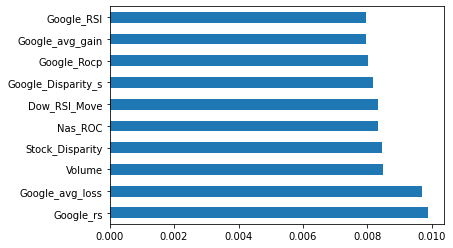

In [344]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')